<a href="https://colab.research.google.com/github/jyoti612/Movie-Recommendation-System/blob/main/MOVIE_RECOMMENDATION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import math
import itertools
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from IPython.display import SVG
from sklearn.neighbors import NearestNeighbors
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

In [ ]:
filename = '/content/drive/My Drive/Mydataset/ratings.csv'
rates= pd.read_csv(filename)
filename1 = '/content/drive/My Drive/Mydataset/movies.csv'
movies= pd.read_csv(filename1)

In [ ]:

# we do not care when the user rated the particular movie!
rates.drop(['timestamp'], axis=1, inplace=True)
print('table of rates : (rows, features): ',rates.shape)

print('table of movies : (rows, features): ',movies.shape)
rates.head()

table of rates : (rows, features):  (100836, 3)
table of movies : (rows, features):  (9742, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
users = rates.userId.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
Movies = rates.movieId.unique()
movie_map = {i:val for i,val in enumerate(Movies)}
inverse_movie_map = {val:i for i,val in enumerate(Movies)}

print("We have %d users"%users.shape[0])
print("We have %d movies"%Movies.shape[0])

We have 610 users
We have 9724 movies


In [ ]:
ratings_df = rates.groupby(['userId','movieId']).aggregate(np.max)
print(len(ratings_df))
if (len(ratings_df) == rates.shape[0]):
  print("there are no such cases where the user has rated the same movie twice.")

100836
there are no such cases where the user has rated the same movie twice.


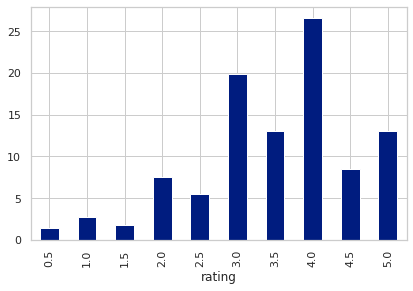

In [ ]:
count_rates = rates.groupby('rating').count()
count_rates['perc_total']=round(count_rates['userId']*100/count_rates['userId'].sum(),1)
count_rates['perc_total'].plot.bar()

In [ ]:
ratedmovies = pd.merge(rates, movies, on = 'movieId')
ratedmovies.tail()

,userId,movieId,rating,title,genres
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller
100835,610,163981,3.5,31 (2016),Horror


In [ ]:
# Create a function to find genres in the dataset
genres = {}
def find_genres():
  for genre in movies['genres']:
    words = genre.split('|')
    for word in words:
      genres[word] = genres.get(word, 0) + 1

find_genres()
genres['None'] = genres.pop('(no genres listed)')
listofgenres = list(genres.keys())
genres

{'Action': 1828,
 'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Crime': 1199,
 'Documentary': 440,
 'Drama': 4361,
 'Fantasy': 779,
 'Film-Noir': 87,
 'Horror': 978,
 'IMAX': 158,
 'Musical': 334,
 'Mystery': 573,
 'None': 34,
 'Romance': 1596,
 'Sci-Fi': 980,
 'Thriller': 1894,
 'War': 382,
 'Western': 167}

In [ ]:
# GENRES = movies['genres']
MoviesWithGenres = movies.copy()
for genre in listofgenres :
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis = 1)
MoviesWithGenres.head()

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,None
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
avg_movie_rating = pd.DataFrame(rates.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index
avg_rating_all= rates['rating'].mean()
min_reviews=20
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.index.name = None

def weighted_rating(x, m=min_reviews, C=avg_rating_all):
  v = x['count']
  R = x['mean']
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)

movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
# movie_score.head()
movie_score = pd.merge(movie_score,MoviesWithGenres,on='movieId')
# movie_score.head()
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,count,mean,weighted_score,genres
101,"Shawshank Redemption, The (1994)",317,4.429022,4.373980,Crime|Drama
223,"Godfather, The (1972)",192,4.289062,4.214770,Crime|Drama
652,Fight Club (1999),218,4.272936,4.208114,Action|Crime|Drama|Thriller
81,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.177237,Action|Adventure|Sci-Fi
25,"Usual Suspects, The (1995)",204,4.237745,4.172014,Crime|Mystery|Thriller
159,Schindler's List (1993),220,4.225000,4.164713,Drama|War
313,"Godfather: Part II, The (1974)",129,4.259690,4.157927,Crime|Drama
94,Pulp Fiction (1994),307,4.197068,4.154529,Comedy|Crime|Drama|Thriller
295,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.153814,Action|Adventure|Sci-Fi
1088,"Dark Knight, The (2008)",149,4.238255,4.151072,Action|Crime|Drama|IMAX


In [ ]:
def best_by_genre(genre,top_n):
  return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

best_by_genre('Drama',5)


,title,count,mean,weighted_score
101,"Shawshank Redemption, The (1994)",317,4.429022,4.373980
223,"Godfather, The (1972)",192,4.289062,4.214770
652,Fight Club (1999),218,4.272936,4.208114
159,Schindler's List (1993),220,4.225000,4.164713
313,"Godfather: Part II, The (1974)",129,4.259690,4.157927


In [ ]:
df_n_ratings = pd.DataFrame(ratedmovies.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(ratedmovies.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


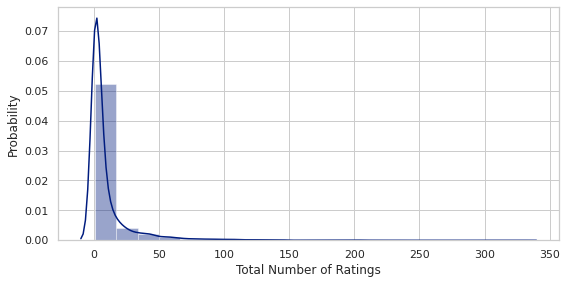

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


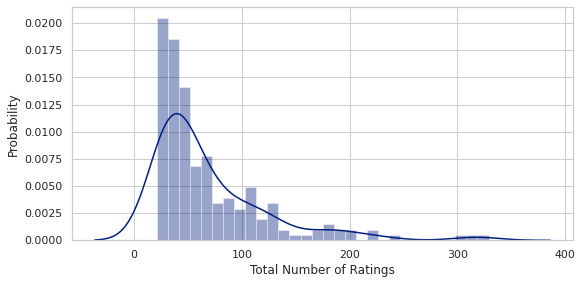

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(best_by_genre('Drama',200)['count'], bins=30)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

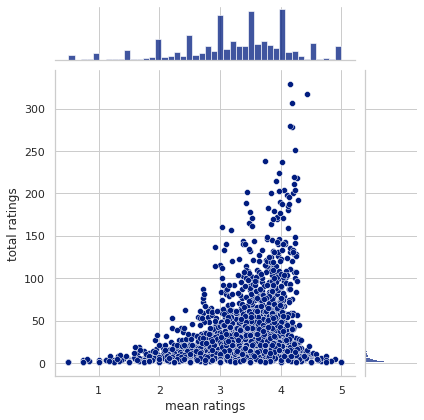

In [ ]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

In [ ]:
# Break up the big genre string into a string array
moviesforcontent = movies.copy()
moviesforcontent['genres'] = moviesforcontent['genres'].str.split('|')
# Convert genres to string value
moviesforcontent['genres'] = moviesforcontent['genres'].fillna("").astype('str')
moviesforcontent.head()

,movieId,title,genres
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II (1995),['Comedy']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(moviesforcontent['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

In [ ]:
def genre_recommendations(title):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:21]
  movie_indices = [i[0] for i in sim_scores]
  return titles.iloc[movie_indices]

In [ ]:
genre_recommendations('Emerald Forest, The (1985)').head(10)

986                                  Ben-Hur (1959)
1331               Man in the Iron Mask, The (1998)
1488                 Poseidon Adventure, The (1972)
1494    Seven Samurai (Shichinin no samurai) (1954)
1772                     Emerald Forest, The (1985)
1821                Karate Kid, Part II, The (1986)
2177                     Plunkett & MaCleane (1999)
2187               Sanjuro (Tsubaki Sanjûrô) (1962)
2674                               Gladiator (2000)
4391              Flight of the Phoenix, The (1965)
Name: title, dtype: object

In [ ]:
genre_recommendations('Ben-Hur (1959)').head(10)

986                                  Ben-Hur (1959)
1331               Man in the Iron Mask, The (1998)
1488                 Poseidon Adventure, The (1972)
1494    Seven Samurai (Shichinin no samurai) (1954)
1772                     Emerald Forest, The (1985)
1821                Karate Kid, Part II, The (1986)
2177                     Plunkett & MaCleane (1999)
2187               Sanjuro (Tsubaki Sanjûrô) (1962)
2674                               Gladiator (2000)
4391              Flight of the Phoenix, The (1965)
Name: title, dtype: object